Use language model to create word embeddings

https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html

In [4]:
# Author: Robert Guthrie

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [5]:
CONTEXT_SIZE = 2
EMBEDDING_DIM = 10
# We will use Shakespeare Sonnet 2
test_sentence = """When forty winters shall besiege thy brow,
And dig deep trenches in thy beauty's field,
Thy youth's proud livery so gazed on now,
Will be a totter'd weed of small worth held:
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say, within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserv'd thy beauty's use,
If thou couldst answer 'This fair child of mine
Shall sum my count, and make my old excuse,'
Proving his beauty by succession thine!
This were to be new made when thou art old,
And see thy blood warm when thou feel'st it cold.""".split()
# we should tokenize the input, but we will ignore that for now
# build a list of tuples.  Each tuple is ([ word_i-2, word_i-1 ], target word)
trigrams = [([test_sentence[i], test_sentence[i + 1]], test_sentence[i + 2])
            for i in range(len(test_sentence) - 2)]
# print the first 3, just so you can see what they look like
print(trigrams[:3])


[(['When', 'forty'], 'winters'), (['forty', 'winters'], 'shall'), (['winters', 'shall'], 'besiege')]


In [58]:

vocab = set(test_sentence)
word_to_ix = {word: i for i, word in enumerate(vocab)}


class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs


losses = []
loss_function = nn.NLLLoss()
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.001)

for epoch in range(20):
    total_loss = 0
    for context, target in trigrams:

        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance
        model.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        log_probs = model(context_idxs)

        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()
    losses.append(total_loss)
print(losses)  # The loss decreased every iteration over the training data!

[517.6855874061584, 515.2583112716675, 512.8455443382263, 510.44680070877075, 508.06000661849976, 505.6846959590912, 503.31996417045593, 500.9646716117859, 498.6180672645569, 496.2809739112854, 493.9519073963165, 491.62920689582825, 489.3136067390442, 487.0050518512726, 484.7002913951874, 482.40004682540894, 480.10377383232117, 477.8111732006073, 475.52171659469604, 473.234503030777]


In [16]:
len(vocab), model.embeddings

(97, Embedding(97, 10))

In [17]:
model.embeddings(torch.tensor(0))

tensor([-1.5251, -0.7513, -0.6535, -1.6088, -0.1007, -0.6106, -0.9808, -1.6081,
        -0.7138,  0.3052], grad_fn=<EmbeddingBackward>)

In [18]:
for word in list(vocab)[:5]:
    print(f'{word}: {model.embeddings(torch.tensor(word_to_ix[word]))}')

where: tensor([-1.5251, -0.7513, -0.6535, -1.6088, -0.1007, -0.6106, -0.9808, -1.6081,
        -0.7138,  0.3052], grad_fn=<EmbeddingBackward>)
shall: tensor([-0.7771, -0.2513, -0.2223,  1.6869,  0.2297,  0.4671, -0.6973, -1.1613,
         0.6983,  0.1990], grad_fn=<EmbeddingBackward>)
thine: tensor([ 0.8661,  0.2439, -0.6639,  0.8082,  1.1022, -0.1753, -2.2464, -1.4475,
         0.0609, -0.6183], grad_fn=<EmbeddingBackward>)
be: tensor([-0.7991, -0.1321,  1.8789, -0.0717,  0.1577, -0.7723,  0.1979,  0.0457,
         0.1515, -0.4758], grad_fn=<EmbeddingBackward>)
weed: tensor([-0.1109,  0.2936, -0.1575, -0.0292,  2.3578, -1.0366,  1.5747, -0.6295,
        -0.9278,  0.5448], grad_fn=<EmbeddingBackward>)


In [34]:
embeddings = model.embeddings.weight.data.numpy()
embeddings[:5]

array([[-1.5251077 , -0.75129277, -0.6535014 , -1.6087608 , -0.10070229,
        -0.6105607 , -0.9807688 , -1.6080558 , -0.7138467 ,  0.305238  ],
       [-0.7771171 , -0.2513143 , -0.22233295,  1.6868888 ,  0.22971532,
         0.46711418, -0.697322  , -1.1612613 ,  0.6982683 ,  0.19900483],
       [ 0.8660686 ,  0.2439151 , -0.66387254,  0.8082408 ,  1.1022061 ,
        -0.1753335 , -2.2464385 , -1.4474938 ,  0.06092361, -0.6183387 ],
       [-0.79913396, -0.13213763,  1.8789219 , -0.07171019,  0.15773693,
        -0.77234983,  0.19793487,  0.04567229,  0.15146196, -0.47579876],
       [-0.11085682,  0.29363558, -0.15749288, -0.02920792,  2.3577716 ,
        -1.0365736 ,  1.5746506 , -0.62954897, -0.92780024,  0.54475147]],
      dtype=float32)

In [43]:
import pandas as pd
df = pd.DataFrame(data=embeddings)
#df['word'] = vocab
df.head()

,0,1,2,3,4,5,6,7,8,9
0,-1.525108,-0.751293,-0.653501,-1.608761,-0.100702,-0.610561,-0.980769,-1.608056,-0.713847,0.305238
1,-0.777117,-0.251314,-0.222333,1.686889,0.229715,0.467114,-0.697322,-1.161261,0.698268,0.199005
2,0.866069,0.243915,-0.663873,0.808241,1.102206,-0.175333,-2.246439,-1.447494,0.060924,-0.618339
3,-0.799134,-0.132138,1.878922,-0.071710,0.157737,-0.772350,0.197935,0.045672,0.151462,-0.475799
4,-0.110857,0.293636,-0.157493,-0.029208,2.357772,-1.036574,1.574651,-0.629549,-0.927800,0.544751


In [44]:
#t-SNE
#https://www.datacamp.com/community/tutorials/introduction-t-sne
#https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

from sklearn.manifold import TSNE
import time
time_start = time.time()

sne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = sne.fit_transform(df)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 96 nearest neighbors...
[t-SNE] Indexed 97 samples in 0.000s...
[t-SNE] Computed neighbors for 97 samples in 0.035s...
[t-SNE] Computed conditional probabilities for sample 97 / 97
[t-SNE] Mean sigma: 1.996420
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.114323
[t-SNE] KL divergence after 300 iterations: 1.075104
t-SNE done! Time elapsed: 0.361741304397583 seconds


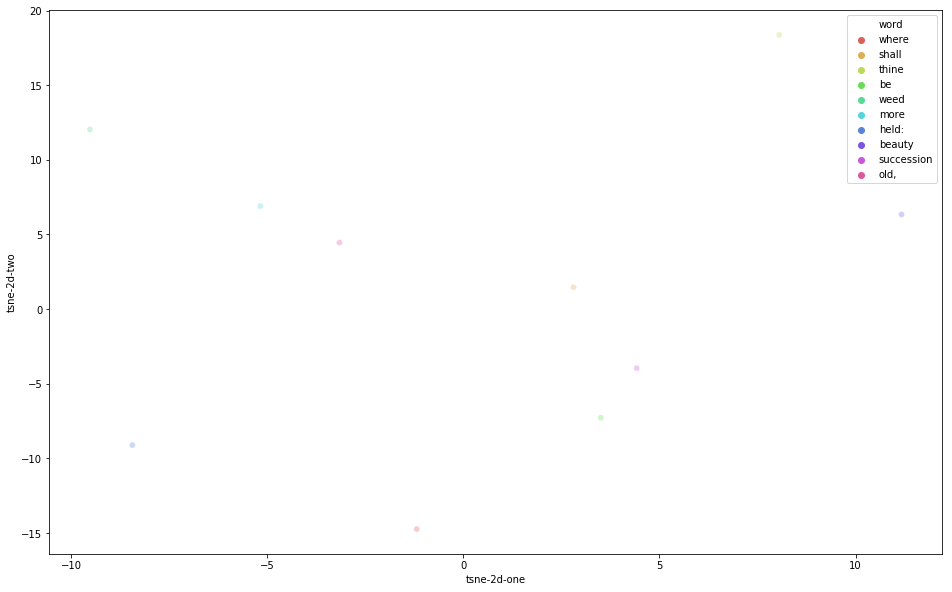

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
df['word'] = vocab

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="word",
    palette=sns.color_palette("hls", 10),
    data=df.head(10),
    legend="full",
    alpha=0.3
)